#  手書き文字(ひらがな73文字)認識モデルの構築

## 概要
MNIST手書き文字認識で0から9までのラベルを持った10種類の画像の分類を行ったが、更に応用して日本語手書き文字認識モデルを構築していく。構築には2種類のモデルを作成し、ひらがな73文字版の分類と、漢字300文字版の分類の2種類を行う。

> http://lab.ndl.go.jp/cms/hiragana73  
> http://lab.ndl.go.jp/cms/kanji300

In [1]:
# 画像や前処理周りのimport
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
from tqdm import tqdm_notebook as tqdm
import pandas as pd
%matplotlib inline

from sklearn.model_selection import train_test_split

# 深層学習周りのimport
import keras
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.utils import np_utils
from keras.optimizers import SGD, Adadelta, Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

/Users/intel0tw5727/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# バージョン確認
import matplotlib
import sklearn
import tqdm as tm
print("numpy => {}".format(np.__version__))
print("matplotlib => {}".format(matplotlib.__version__))
print("pandas => {}".format(pd.__version__))
print("OpenCV => {}".format(cv2.__version__))
print("tqdm => {}".format(tm.__version__))
print("scikit-learn => {}".format(sklearn.__version__))
print("keras => {}".format(keras.__version__))

numpy => 1.14.1
matplotlib => 2.1.2
pandas => 0.22.0
OpenCV => 3.4.1
tqdm => 4.23.4
scikit-learn => 0.19.1
keras => 2.2.0


## データセット文字コード対応表の読み込み

In [3]:
jp_char_df = pd.read_csv("../data/hiragana_table.csv")

In [4]:
jp_char_df.head()

,char,dir,img_num
0,あ,U3042,"1,208"
1,い,U3044,"1,122"
2,う,U3046,"1,148"
3,え,U3048,"1,077"
4,お,U304A,"1,283"


In [5]:
# 漢字データセット総数: 146,157
# 1ラベル約100~1000程度
dir_path = "../data/hiragana73"
img_list = []
label_list = []

for root, dirs, files in tqdm(os.walk(dir_path)):
    if len(files) == 0:
        labels = dirs
        labels_dict = dict(zip([_ for _ in range(len(labels))], labels))
    else:
        tmp = []
        idx = jp_char_df[jp_char_df.dir == root.split("/")[-1]].index.values[0]
        for file in files:
            img_list.append(cv2.imread(os.path.join(root, file)))
            label_list.append(idx)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

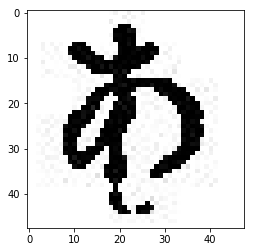

In [6]:
plt.imshow(img_list[0])

In [7]:
img_list[0].shape

(48, 48, 3)

In [8]:
len(img_list)

80000

## データの準備

In [9]:
X, y = np.array(img_list), label_list

In [11]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=98, shuffle=True)

X_train = X_train.reshape(len(X_train), X_train[0].shape[0], X_train[0].shape[1], 3)
X_test = X_test.reshape(len(X_test), X_test[0].shape[0], X_test[0].shape[1], 3)

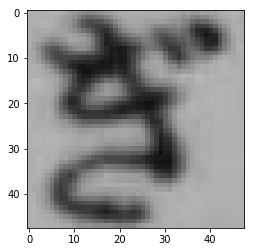

In [13]:
# trainデータの1枚を確認
plt.imshow(X_train[0], cmap="gray")

In [15]:
# testデータの1枚を確認
jp_char_df.loc[y_train[0]]["char"]

'ぎ'

In [16]:
print("X_train.shape -> {}".format(X_train.shape))
print("X_test.shape -> {}".format(X_test.shape))

X_train.shape -> (64000, 48, 48, 3)
X_test.shape -> (16000, 48, 48, 3)


In [17]:
nb_classes = len(labels)
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [18]:
print("y_train.shape -> {}".format(len(y_train)))
print("y_test.shape -> {}".format(len(y_test)))

y_train.shape -> 64000
y_test.shape -> 16000


In [19]:
input_shape = X_train.shape[1:]

## モデルの構築

In [20]:
model = Sequential()

"""
model.add()の中にConv2DやMaxPooling2Dをいれてモデルを作ってみよう

今回使用する関数一覧

model.add(Dense(次元数, activation=活性化関数))
model.add(Flatten()) # 畳み込みし終えた後全結合層につなげるときに使おう
model.add(Conv2D(次元数, kernel_size=フィルターのサイズ,activation=活性化関数,input_shape=input_shape)) #input_shapeは最初のみ使用
model.add(MaxPooling2D(pool_size=プーリングするサイズ))
model.add(Dropout(0から1までの数値)) # 学習するパーセプトロンのうち使用しない割合を設定

その他、調べてみて便利な関数があればぜひ追加してみよう
"""

# Fully connected layer #2
model.add(Dense(len(labels), activation="softmax"))

/Users/intel0tw5727/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, kernel_size=(3, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.


In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 48)        13872     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 48)        192       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 48)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 48)        0         
__________

## モデルの読み込み

model = model_from_json(open("../models/kanji_cnn.json", "r").read())
model.load_weights("../params/kanji_cnn_best_weight.hdf5")

## モデルのコンパイル

In [22]:
"""
モデルを評価する関数をmodel.compile()で定義しよう

実際にmodel.compileの中にはこのようにします

model.compile(loss=誤差関数,
             optimizer=最適化関数,
             metrics=['accuracy']
             )
             
誤差関数
・categorical_crossentropy

最適化関数(好きなものを選ぼう)
・SGD
・Adadelta
・Adam
・RMSprop

評価指標
・accuracy
"""

model.compile(loss="", # 誤差(損失)関数
             optimizer="", # 最適化関数
             metrics=[""] # 評価指標
             )

## 初期モデル・パラメータを保存

In [23]:
init_weights_path = '../models/hiragana_cnn_init_weight.hdf5'
best_weights_path = '../models/hiragana_cnn_best_weight.hdf5'
model.save_weights(init_weights_path, overwrite=True)
model.save_weights(best_weights_path, overwrite=True)

In [25]:
model_path = '../models/hiragana_cnn.json'
model_json = model.to_json()
open(model_path, 'w').write(model_json)

4552

## 学習中のコールバックの設定

In [26]:
callbacks = [
    EarlyStopping(monitor='val_acc', patience=5,mode='max',verbose=1),
    ModelCheckpoint(best_weights_path,monitor='val_acc', save_best_only=True, 
        mode='max',verbose=0)
]

## 学習

In [27]:
tic = time.time()

history = model.fit(X_train, Y_train,
                    batch_size=256,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks=callbacks)

toc = time.time()

print("Execution time: {0:.2f} [sec]".format(toc - tic))

Train on 64000 samples, validate on 16000 samples
Epoch 1/100
 5632/64000 [=>............................] - ETA: 13:05 - loss: 2.0288 - acc: 0.5504

KeyboardInterrupt: 

## 学習結果の可視化

In [29]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.018329777392491982
Test accuracy: 0.9956212370005474


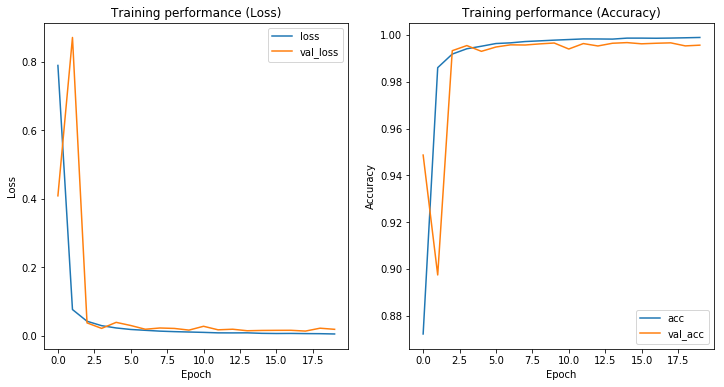

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title('Training performance (Loss)')
ax[0].plot(history.epoch, history.history['loss'], label='loss')
ax[0].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].legend()

ax[1].set_title('Training performance (Accuracy)')
ax[1].plot(history.epoch, history.history['acc'], label='acc')
ax[1].plot(history.epoch, history.history['val_acc'], label='val_acc')
ax[1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1].legend(loc='best')

In [40]:
history_df = pd.DataFrame([history.history["loss"],history.history["acc"],history.history["val_loss"],history.history["val_acc"]])
history_df.index = ["loss", "acc", "val_loss", "val_acc"]

In [44]:
history_df.T.to_csv("../data/learning_result.csv", index=False)

## 予測の可視化

In [31]:
Y_test_pred = model.predict(X_test)

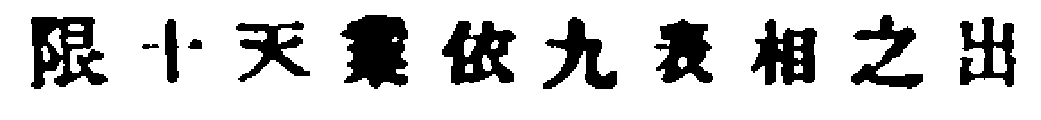

In [32]:
# テストデータの可視化
fig, ax = plt.subplots(1, 10, figsize=(18, 8))

for ii in range(10):
    ax[ii].imshow(X_test[ii].reshape(48, 48), cmap='gray') #iiの値+nでn番目以降のテストデータを出力する．
    ax[ii].axis('off')

In [33]:
kanji_df = pd.read_csv("../data/kanji_table_prop.csv")

In [34]:
# 予測の可視化
[kanji_df.loc[y_pred.argmax()]["char"] for y_pred in Y_test_pred[:10]]

['限', '十', '天', '業', '依', '九', '表', '相', '之', '出']